# Measures of overall disasterness
We want to capture the fact that more intense storms (Fujita scale 5 tornadoes, richter scale 9 earthquakes) are worse than other events, and that deaths are worse than injuries and property damages.  While we provide all these data separately, this is our opportunity to combine them into a custom metric that illustrates just how dangerous it is to live somewhere.  We account for the different magnitudes of earthquakes and tornadoes, for which we have such data, but don't distinguish between the severity of other events.

We recognize that the weights of these factors are chosen arbitrarily, but we think this still conveys more information than not combining these parameters at all, or than giving all sorts of natural disasters equal weight.

In [221]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

# Get counties

In [222]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)
    
display(counties)

(3141, 6)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,..."
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,..."
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...


# Get disaster data
Earthquakes and tornadoes, for which we have the events themselves, need to be aggregated by county in some way that accounts for their intensity.

## Quakes
I choose to aggregate quakes based on the energy they release.  This way we prevent little earthquakes from dominating the conversation, when it's the big ones that really matter.  [This website](https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/magnitudeScaleCalculations.html) says how to calculate quake energy from magnitude.

In [223]:
quakes = geopandas.read_file('../data_output/5__USGS_quakes/quakes1.geojson')
display(quakes)

(2547, 4)


,FIPS,year,magnitude,geometry
0,6029,1996,5.17,POINT (-117.646 35.761)
1,6071,1996,4.16,POINT (-117.62 35.755)
2,6071,1996,4.36,POINT (-117.636 35.779)
3,6071,1996,4.24,POINT (-117.632 35.799)
4,6071,1996,4.19,POINT (-116.943 34.994)


In [224]:
# Calculate the total energy released by each earthquake (in Joules).
quakes['energy'] = 10**(1.5*quakes['magnitude'])

# Create a dataframe that aggregates all earthquakes by county, 
# summing up their magnitude
quakes2 = quakes[['FIPS', 'energy']].groupby('FIPS').sum()\
                                .rename(columns={'energy':'quake_energy'})

display(quakes2)

(191, 1)


,quake_energy
FIPS,
1049,7.943282e+06
1053,1.584893e+07
1063,2.818383e+06
2013,1.597265e+08
2016,1.252253e+09


## Tornadoes
Our NOAA data classifies tornadoes according to the old Fujita scale before 1997, and according to the Enhanced Fujita scale since then.  Both scales are a measure of damages, but are not as readily quantifiable as earthquakes.  I choose to treat them as if they were all on a logarithmic scale.  I selected my parameters such that a category 5 tornado is equivalent to 100 category-0 tornadoes, which matches my intuition for how different in importance they really are.  The relative weights are:

```
cat - weight
F0  - 1
F1  - 3.16
F2  - 10
F3  - 31.6
F4  - 100
F5  - 316
```

In [225]:
tornadoes = geopandas.read_file('../data_output/5__NOAA/tornadoes.geojson')
display(tornadoes)

(30898, 3)


,year,intensity,geometry
0,1996,1,POINT (-89.87 36.18)
1,1996,1,POINT (-90.97 34.55)
2,1996,1,POINT (-92.31999999999999 30.57)
3,1996,0,POINT (-86.97 40.5)
4,1996,2,POINT (-96.15000000000001 33.72)


In [226]:
# Calculate an exponential measure of intensity
tornadoes['exp_intensity'] = 10**(0.5*tornadoes['intensity'])

# Mark all tornadoes with the county where they happened
tornadoes2 = geopandas.sjoin(tornadoes, counties, how='left', op='within')

# Single out only relevant columns, and group by county 
# (again, adding up magnitudes)
tornadoes2 = tornadoes2[['exp_intensity','FIPS']]\
                    .groupby('FIPS').sum()\
                    .rename(columns={'exp_intensity':'tornado_intensity'})

display(tornadoes2)

(2869, 1)


,tornado_intensity
FIPS,
1001,123.706052
1003,107.920998
1005,45.135944
1007,31.298221
1009,273.381497


## Damages

In [227]:
damages = pd.read_csv('../data_output/5__NOAA/damages_by_county.csv')
display(damages)

(3141, 4)


,FIPS,damage,deaths,injuries
0,1001,26788100.0,7.0,96.0
1,1003,54686000.0,29.0,57.0
2,1005,2594000.0,0.0,17.0
3,1007,16973750.0,1.0,20.0
4,1009,33177500.0,1.0,59.0


## Other storms
I'm aggregating all of our best sources for storms here.  I'll use the NOAA data for most types, but FEMA data for hurricanes.  I'll also create columns that tell us how many storms of a given type that county had, as a percentage of the mean national value. 

In [309]:
# Import FEMA data
fema = geopandas.read_file('../data_output/4__FEMA_county/')

# Aggregate by FIPS, keep only useful columns
fema = fema.sort_values('FIPS').set_index(['FIPS'])[['Hurricane']]

# Cast hurricanes as int
fema['Hurricane'] = fema['Hurricane'].astype(int)
    
display(fema)

(3141, 1)


,Hurricane
FIPS,
1001,8
1003,20
1005,8
1007,7
1009,4


In [313]:
# Import NOAA extreme weather events
noaa = pd.read_csv('../data_output/5__NOAA/noaa_2.csv')\

# Aggregate by FIPS, keep only useful columns
noaa = noaa.groupby('FIPS').sum()[['Winter Weather','Storm','Flood','Fire','Heat',
                 'Drought']]

# Rename Winter Weather to Winter
noaa = noaa.rename(columns={'Winter Weather':'Winter'})

display(noaa)

(3141, 6)


,Winter,Storm,Flood,Fire,Heat,Drought
FIPS,,,,,,
1001,17,225,28,0,5,36
1003,5,322,100,0,0,0
1005,7,120,7,0,8,49
1007,18,131,17,0,5,34
1009,33,312,37,0,4,29


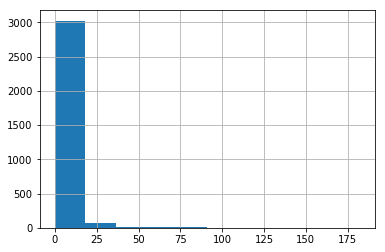

In [322]:
storms.Fire.hist()

In [352]:
# Merge NOAA and FEMA data
storms = pd.merge(noaa, fema, how='left', on='FIPS')

# Create columns that show a county's storm count as a 
# percentage of the national median.  

cols = storms.columns

# Add columns for the median national value of each disaster type.
# Since the national median for Fire is 0, in that case I used 1 instead
# to prevent division by zero errors
for col in cols:
    if storms[col].median() > 0:
        storms['median_' + col] = storms[col].median()
    else:
        storms['median_' + col] = 1
        
# Add columns for disaster counts normalized to that median
for col in cols:
        storms['pct_' + col] = storms[col] / storms[col].median() * 100
        storms['median_' + col] = storms[col].median()
    else:
        storms[new_name] = storms[col] / 1 * 100
        storms['median_' + col] = 1
        
        
# Add county geometries
storms['geometry'] = counties.sort_values('FIPS').set_index('FIPS')['geometry']

# Turn into geopandas object
storms = geopandas.GeoDataFrame(storms)

display(storms)

(3141, 21)


,Winter,Storm,Flood,Fire,Heat,Drought,Hurricane,pct_Winter,median_Winter,pct_Storm,...,pct_Flood,median_Flood,pct_Hurricane,median_Fire,pct_Heat,median_Heat,pct_Drought,median_Drought,median_Hurricane,geometry
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,17,225,28,0,5,36,8,28.333333,60.0,114.795918,...,93.333333,30.0,800.0,1,166.666667,3.0,400.000000,9.0,1.0,POLYGON ((-86.82066986329349 32.34730960076057...
1003,5,322,100,0,0,0,20,8.333333,60.0,164.285714,...,333.333333,30.0,2000.0,1,0.000000,3.0,0.000000,9.0,1.0,POLYGON ((-87.97308978075395 31.16482251520438...
1005,7,120,7,0,8,49,8,11.666667,60.0,61.224490,...,23.333333,30.0,800.0,1,266.666667,3.0,544.444444,9.0,1.0,POLYGON ((-85.74337279655801 31.62624052460075...
1007,18,131,17,0,5,34,7,30.000000,60.0,66.836735,...,56.666667,30.0,700.0,1,166.666667,3.0,377.777778,9.0,1.0,POLYGON ((-87.41985563876936 33.01177307648309...
1009,33,312,37,0,4,29,4,55.000000,60.0,159.183673,...,123.333333,30.0,400.0,1,133.333333,3.0,322.222222,9.0,1.0,POLYGON ((-86.96799449037186 33.86045466926403...


In [335]:
# Export as geoJSON file
storms.to_file("../data_output/6__danger/storms.geojson", driver='GeoJSON')

In [350]:
# Remove geometry and export as CSV
storms_plain = storms.drop(columns='geometry')
storms_plain.to_csv("../data_output/6__danger/storms.csv")

# Create aggregate measures of danger
I'll account separately for events (storms, tornadoes and quakes) and overall costs (property damage, deaths, and injuries).  

## Combine everything into a single dataframe

In [347]:
# Merge quakes with counties to create a new dataframe called 'danger'.
danger = pd.merge(counties, quakes2, how='left', on='FIPS')\
                                                .fillna(0)
# Merge tornadoes2 into danger
danger = pd.merge(danger, tornadoes2, how='left', on='FIPS')\
                                                .fillna(0)
# Merge damages into danger
danger = pd.merge(danger, damages, how='left', on='FIPS')

# Merge storms into danger
danger = pd.merge(danger, storms[['Winter', 'Storm', 
        'Flood', 'Fire', 'Heat', 'Drought', 'Hurricane']],
                  how='left', on='FIPS')

# Drop useless columns
danger = danger.drop(columns=['NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS'])

# Set FIPS as the index.
danger = danger.sort_values('FIPS').set_index('FIPS')

In [348]:
display(danger)

(3141, 13)


,geometry,quake_energy,tornado_intensity,damage,deaths,injuries,Winter,Storm,Flood,Fire,Heat,Drought,Hurricane
FIPS,,,,,,,,,,,,,
1001,POLYGON ((-86.82066986329349 32.34730960076057...,0.0,123.706052,26788100.0,7.0,96.0,17,225,28,0,5,36,8
1003,POLYGON ((-87.97308978075395 31.16482251520438...,0.0,107.920998,54686000.0,29.0,57.0,5,322,100,0,0,0,20
1005,POLYGON ((-85.74337279655801 31.62624052460075...,0.0,45.135944,2594000.0,0.0,17.0,7,120,7,0,8,49,8
1007,POLYGON ((-87.41985563876936 33.01177307648309...,0.0,31.298221,16973750.0,1.0,20.0,18,131,17,0,5,34,7
1009,POLYGON ((-86.96799449037186 33.86045466926403...,0.0,273.381497,33177500.0,1.0,59.0,33,312,37,0,4,29,4


## Costs
I'll turn everything into dollars, including deaths and injuries.  I'll turn deaths into dollars using the [statistical value of a human life in the USA](https://en.wikipedia.org/wiki/Value_of_life#United_States)
, which I approximate as 9 million dollars.  I'll turn injuries into dollars by assuming that an injury costs on average 1 year of quality-adjusted life, which is commonly set at 50,000 dollars.  I'll then create a logarithmic version of this cost scale (that will be easier to visualize on a map) and bin it into six sensible bins.

In [284]:
# Create unified measure of cost
danger['linear_cost'] = danger.damage + danger.deaths*9000000 + danger.injuries*50000

# Figure out cost as a percentage of national mean.
usa_median = danger.linear_cost.median()
danger['cost_percent_of_median'] = danger['linear_cost'] / usa_median *100

# Create logarithmic measure of cost
danger['log_cost'] = np.log10(danger['linear_cost']+1)

# Normalize log_cost so that it has a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import robust_scale
danger['cost'] = robust_scale(danger['log_cost'])

# Bin cost into 1, 2, or >2 standard deviations away from the mean
danger['cost_bins'] = pd.cut(danger['cost'], bins=[-20,-2,-1,0,1,2,20], 
                               include_lowest=True, retbins=False, labels=False)

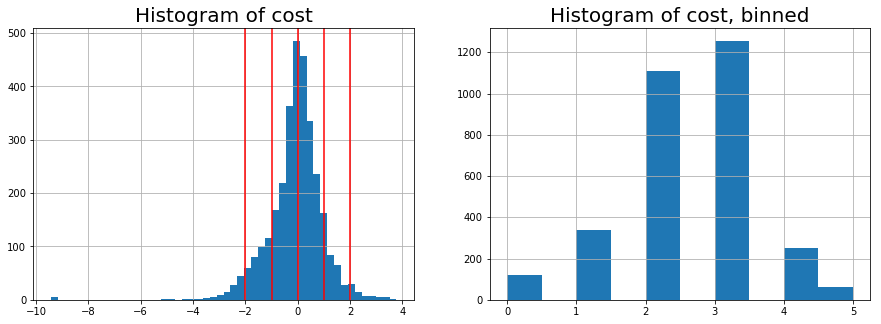

In [295]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(15,5))
danger['cost'].hist(ax=ax, bins=50);
ax.axvline(-2, color='r')
ax.axvline(-1, color='r')
ax.axvline(0, color='r')
ax.axvline(1, color='r')
ax.axvline(2, color='r')
# ax.set_xlabel('Cost (logarithmic)')
# ax.set_ylabel('Number of counties')
ax.set_title('Histogram of cost', fontsize=20)

danger['cost_bins'].hist(ax=ax2);
ax2.set_title('Histogram of cost, binned', fontsize=20)
plt.show()

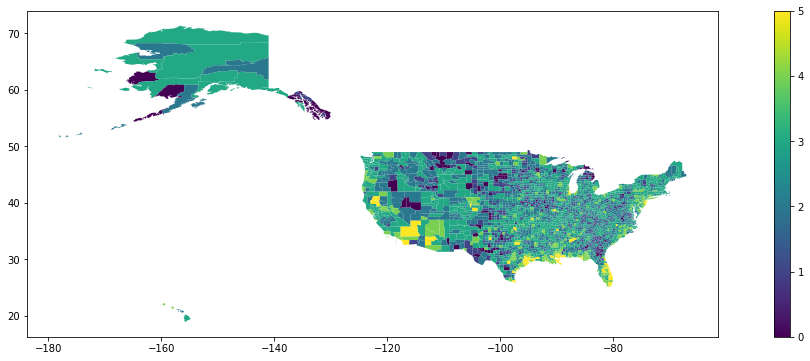

In [296]:
danger.plot(column='cost_bins', figsize=(20,6), legend=True);

## Disaster counts
I want to create a neat bell curve of disaster frequency, based on combining various measures of disaster frequencies, some of them logarithmic, and all of them normalized and weighted so that more powerful disasters (data only available for quakes and tornadoes) have greater weight.

In [351]:
display(danger)

(3141, 13)


,geometry,quake_energy,tornado_intensity,damage,deaths,injuries,Winter,Storm,Flood,Fire,Heat,Drought,Hurricane
FIPS,,,,,,,,,,,,,
1001,POLYGON ((-86.82066986329349 32.34730960076057...,0.0,123.706052,26788100.0,7.0,96.0,17,225,28,0,5,36,8
1003,POLYGON ((-87.97308978075395 31.16482251520438...,0.0,107.920998,54686000.0,29.0,57.0,5,322,100,0,0,0,20
1005,POLYGON ((-85.74337279655801 31.62624052460075...,0.0,45.135944,2594000.0,0.0,17.0,7,120,7,0,8,49,8
1007,POLYGON ((-87.41985563876936 33.01177307648309...,0.0,31.298221,16973750.0,1.0,20.0,18,131,17,0,5,34,7
1009,POLYGON ((-86.96799449037186 33.86045466926403...,0.0,273.381497,33177500.0,1.0,59.0,33,312,37,0,4,29,4


In [ ]:
# Aggregate together all the events that don't have explicit intensity measures,
# Using my own estimates of how important they should be.
danger['arbitrary1'] = danger['Winter']\
                    + danger['Storm']\ 
                    + danger['Flood']\ 
                    + danger['Fire']\ 
                    + danger['Heat']\ 
                    + danger['Drought']\ 
                    + danger['Hurricane'] * 10

danger['storminess'] = np.log10(danger.total_storms + danger.quake_magnitude*100 + danger.tornado_intensity*100 +1)

# Create unified measure of badness
danger['badness'] = danger['log_cost'] + danger['storminess']

## Create binned versions of log_cost, storminess, and badness

danger['storminess_bins'] = pd.cut(danger['storminess'], bins=[0,2,2.5,3,3.5,4,20], 
                               include_lowest=True, retbins=False, labels=False)



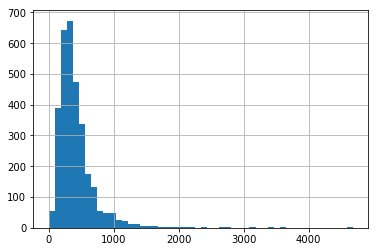

In [239]:
danger.total_storms.hist(bins=50)

## Binning storminess

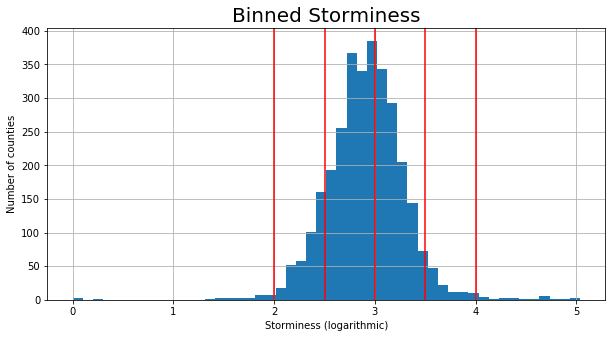

In [183]:
fig, ax = plt.subplots(figsize=(10,5))
danger['storminess'].hist(ax=ax, bins=50);
ax.axvline(2, color='r')
ax.axvline(2.5, color='r')
ax.axvline(3, color='r')
ax.axvline(3.5, color='r')
ax.axvline(4, color='r')
ax.set_xlabel('Storminess (logarithmic)')
ax.set_ylabel('Number of counties')
ax.set_title('Binned Storminess', fontsize=20)
plt.show()

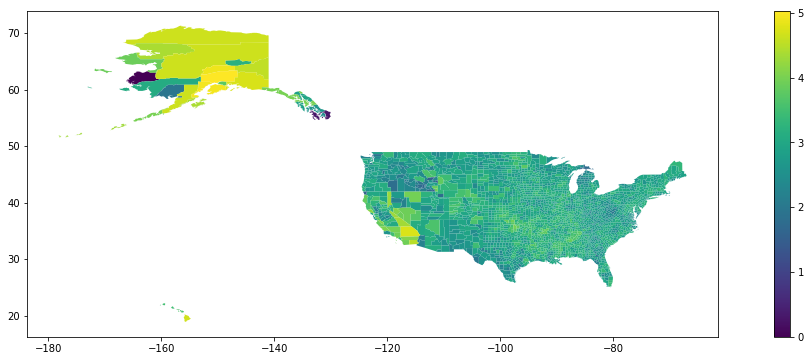

In [179]:
danger.plot(column='storminess', figsize=(20,6), legend=True);

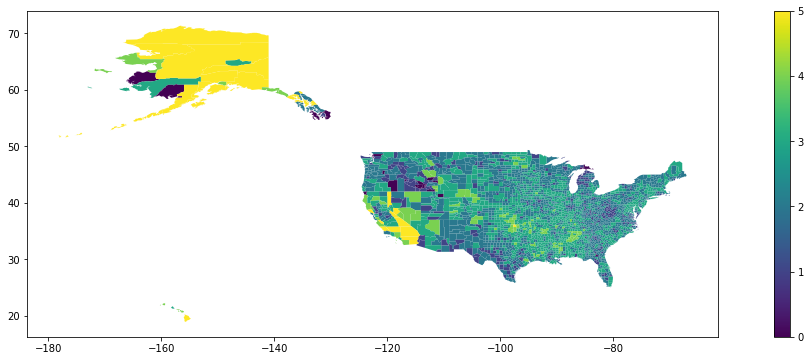

In [180]:
danger.plot(column='storminess_bins', figsize=(20,6), legend=True);

# Binning total events

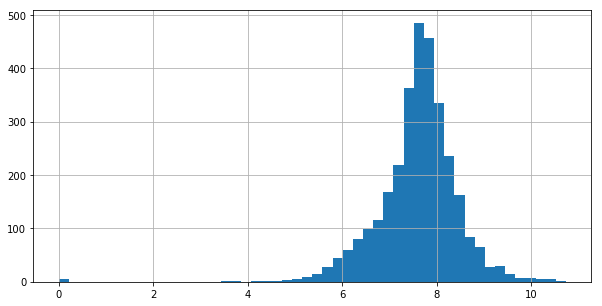

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
danger['log_cost'].hist(ax=ax, bins=50);
# ax.axvline(4, color='r')
# ax.axvline(4, color='r')
# ax.axvline(5, color='r')
# ax.axvline(6, color='r')
# ax.axvline(7, color='r')
# ax.axvline(8, color='r')
# ax.set_xlabel('Log(Number of incidents)')
# ax.set_ylabel('Number of counties')
plt.show()

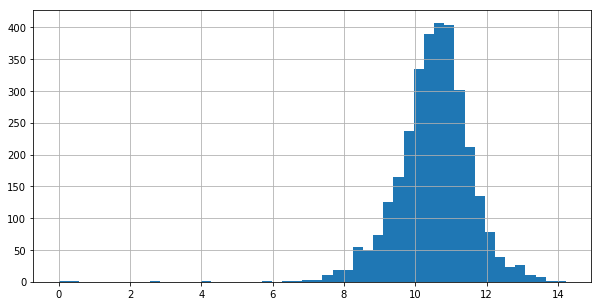

In [167]:
fig, ax = plt.subplots(figsize=(10,5))
danger['badness'].hist(ax=ax, bins=50);
plt.show()

In [168]:
display(danger)

(3141, 12)


,FIPS,geometry,quake_magnitude,tornado_intensity,damage,deaths,injuries,total_storms,overall_cost,storminess,log_cost,badness
0,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",0.00,3.0,2730200.0,0.000000,4.000000,294,2.930200e+06,2.774517,6.466897,9.241414
1,53019,POLYGON ((-118.8516288013387 47.94956368481996...,0.00,0.0,24320500.0,0.000000,0.000000,251,2.432050e+07,2.401401,7.385973,9.787373
2,53065,"POLYGON ((-117.438831576286 48.04411548512263,...",0.00,2.0,5495500.0,2.666667,10.666667,507,3.002883e+07,2.850033,7.477538,10.327572
3,53047,"POLYGON ((-118.972093862835 47.93915200536639,...",13.35,0.0,392974160.0,15.800000,26.400000,987,5.364942e+08,3.366049,8.729565,12.095614
4,53051,POLYGON ((-117.4385804303028 48.99991850672649...,0.00,0.0,11105000.0,4.666667,13.666667,504,5.378833e+07,2.703291,7.730688,10.433979


# Old cells

In [169]:
# Export as geoJSON file
danger.to_file("../data_output/6__danger/danger2.geojson", driver='GeoJSON')

In [ ]:
# Export as CSV
dis5 = dis4.drop(columns='geometry')
dis5.to_csv("../data_output/6__danger/danger.csv")

# Generating disaster level labels

In [ ]:
# Histogram to visualize the distribution of danger scores
dis5.hist(bins=50);

Danger levels have a long-tailed distribution, so it's probably better to assign an overall danger score based on the log of danger rather than danger itself.

In [ ]:
# Generate new dataframe
dis6 = dis4.copy()

# Generate new column with the log of danger.
dis6['log_danger'] = np.log(dis6['danger'] + 1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
dis6['log_danger'].hist(ax=ax, bins=50);
ax.axvline(4, color='r')
ax.axvline(4, color='r')
ax.axvline(5, color='r')
ax.axvline(6, color='r')
ax.axvline(7, color='r')
ax.axvline(8, color='r')
ax.set_xlabel('Log(Number of incidents)')
ax.set_ylabel('Number of counties')
plt.show()

In [ ]:
# Create an array of numerical bins

danger_bins_numerical = pd.cut(dis6['log_danger'], bins=[0,4,5,6,7,8,12], 
                               include_lowest=True, retbins=False, labels=False)

# Create an array of labeled bins. Intervals are evenly spaced within the 
# log-normal bell curve.
danger_bins_labels = pd.cut(dis6['log_danger'], bins=[0,4,5,6,7,8,12], 
                            include_lowest=True,retbins=True, 
                            labels=['Very Low Risk','Low Risk','Medium Risk',
                                    'High Risk','Very High Risk','Extremely High Risk'])[0]

# Incorporate them into the dataframe
dis6['bins_num'] = danger_bins_numerical
dis6['bins_labels'] = danger_bins_labels

In [ ]:
# All the labels are represented.
dis6.bins_labels.unique()

In [ ]:
dis6.plot(column='bins_num', figsize=(15,6), legend=True);

In [ ]:
dis6[dis6.bins_num == 0].head(30)

In [ ]:
dis7 = dis6[['danger','bins_num','bins_labels']]

# Export as CSV
dis7.to_csv("../data_output/6__danger/danger_labels.csv")